In [281]:
%cd G:\Meine Ablage\TechLabs\Scam Busters

G:\Meine Ablage\TechLabs\Scam Busters


In [282]:
# imports
import requests
import json
import pandas as pd
import numpy as np
from os import listdir
from os.path import isfile, join
import inspect

import datetime as dt
features_id = dt.date.today().strftime('%Y-%m-%d')

# settings to load data
mypath = 'data/04_raw_financial/'

onlyfiles = [mypath + f for f in listdir(mypath) if (isfile(join(mypath, f)))]

onlyfiles = [f for f in onlyfiles if 'simplified' in f ]


In [283]:
# set threshold value for the pump indicator (max return within 1 minute)
successful_pump_threshold = 1.1
time_to_pump = 5
expected_pump_row = -31

In [284]:
pump_status_dict = {
    0:'failed',
    1:'success',
    2:'maybe - wrong time',
    3:'maybe - low initial return',
    4:'maybe - different reason'
}

import pickle
with open('pump_status_dictionary.pkl', 'wb') as f:
    pickle.dump(pump_status_dict, f)

In [285]:
def get_pump_success(indicator, indicator_idx, df_length):
    if (indicator >= successful_pump_threshold) & (indicator_idx == df_length+expected_pump_row):
        return 1
    if (indicator >= successful_pump_threshold):
        return 2
    else:
        return 0

def pump_success_indicator(file):
    df = pd.read_csv(file)
    high, open = df.high, df.open
    idx_indicator = (high/open).idxmax()
    indicator = (high/open)[idx_indicator]
    high_max=df['high'].rolling(2).max()
    open_max=df['open'].rolling(2).max()
    open_max = open_max.dropna().reset_index(drop=True)
    max_possible_return = df.iloc[-40:-25].high.max() / df.iloc[-40:-25].low.min()
    max_5m_return = (high_max/open_max).dropna().max()
    max_5m_return_idx = (high_max/open_max).dropna().idxmax()
    pump_success = get_pump_success(indicator,idx_indicator,len(df))
    return {'indicator':indicator, 'idx_indicator':idx_indicator,
        'max_possible_return':max_possible_return, 'pump_success':pump_success}

all_indicators = pd.DataFrame([
    pump_success_indicator(file)
    for file
    in onlyfiles
])

In [286]:
all_indicators

,indicator,idx_indicator,max_possible_return,pump_success
0,1.041742,1591,1.001736,0
1,1.749237,5969,1.750881,1
2,2.101695,5969,2.293103,1
3,1.593247,5969,1.616733,1
4,1.747833,5969,1.784393,1
...,...,...,...,...
116,6.035088,5969,6.198198,1
117,1.025472,523,1.006855,0
118,1.024691,5880,1.024691,0
119,1.225806,5974,1.245902,2


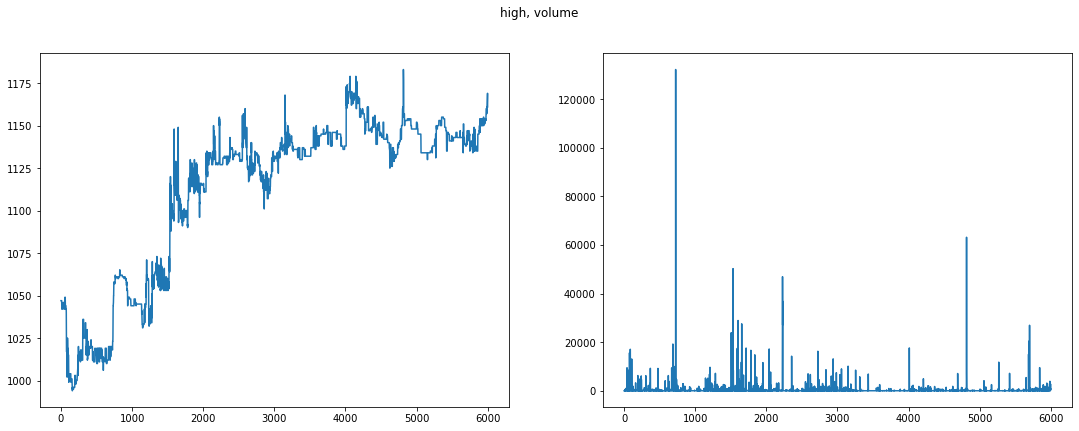

In [309]:
id = 0
raw_df = pd.read_csv(onlyfiles[id])
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('high, volume')
fig.set_size_inches(18.5, 6.5)
ax1.plot(raw_df['Unnamed: 0'], raw_df.high)
ax2.plot(raw_df['Unnamed: 0'], raw_df.volume)

In [288]:
def returns_before_pump(df,hours_to_pump):
    '''returns the ROI if investing hours_to_pump 
    number of hours before the exit and exiting
    time_to_pump minutes before the pump'''
    roi = df.high.iloc[-1] / df.high.iloc[ - hours_to_pump * 60 - 1 ]
    return roi

def get_btc_volume(df,hours_to_pump):
    '''returns the total volume for t hours 
    up until x minutes before the pump'''
    return df.quote_asset_volume.iloc[-hours_to_pump*60-1:].sum()

def get_coin_volume(df,hours_to_pump):
    return df.volume.iloc[-hours_to_pump*60-1:].sum()

def get_log_return(df,hours_to_pump):
    return 1

In [289]:
# full engineering for a single df
def compute_features(df):
    # cut off everything that will be unknown in reality
    df_cutoff = df.iloc[:expected_pump_row-time_to_pump]
    df_to_1h = df.iloc[:expected_pump_row-60]

    # instantiate empty dict
    features = {}

    # get features which need a timespan to make sense
    hrs = [1,3,12,24,36,48,60,72]
    for h in hrs:
        features[f'return_{h}hrs_to_cutoff'] = returns_before_pump(df_cutoff,h)
        features[f'return_{h}hrs_to_1h'] = returns_before_pump(df_to_1h,h)
        features[f'btc_volume_{h}hrs_to_cutoff'] = get_btc_volume(df_cutoff,h)
        features[f'btc_volume_{h}hrs_to_1h'] = get_btc_volume(df_to_1h,h)
        features[f'coin_volume_{h}hrs_to_cutoff'] = get_coin_volume(df_cutoff,h)
        features[f'coin_volume_{h}hrs_to_1h'] = get_coin_volume(df_to_1h,h)
    # features to be added
    ## coin value in usd
    ## return std
    ## volume std
    ## volume hourly zscore (maybe quarter hourly)
    ## pumped_before

        
    return features

In [290]:
# add the label
# pump column

In [291]:
# get all features
engineered_df = pd.DataFrame([
    compute_features(pd.read_csv(file))
    for file
    in onlyfiles
])
feature_list = engineered_df.columns

In [292]:
engineered_df.loc[:,'pumped'] = all_indicators.pump_success.replace(2,0)

In [293]:
# add symbols to the engineered_df

def get_symbol(path_str):
    file_str=path_str[path_str.find('pump')+5:]
    file_str = file_str[:file_str.find('_')]
    return file_str.upper()

In [294]:
engineered_df.loc[:,'symbol'] = [
    get_symbol(path_str)
    for path_str in onlyfiles
]

In [295]:
# get market cap data

from requests import Request, Session
from requests.exceptions import ConnectionError, Timeout, TooManyRedirects
import json

url = 'https://pro-api.coinmarketcap.com/v1/cryptocurrency/listings/latest'
parameters = {
  'start':'1',
  'limit':'5000',
  'convert':'USD'
}
headers = {
  'Accepts': 'application/json',
  'X-CMC_PRO_API_KEY': '541aa958-c55e-4527-a3b4-5734f576b6bf',
}

session = Session()
session.headers.update(headers)

try:
  response = session.get(url, params=parameters)
  data = json.loads(response.text)
except (ConnectionError, Timeout, TooManyRedirects) as e:
  print(e)

# unpack and simplify data
market_cap_df = pd.DataFrame(response.json()['data'])
unpacked = pd.DataFrame(market_cap_df.quote.tolist())
unpacked = pd.DataFrame(unpacked.USD.tolist())
market_cap_df.loc[:,'market_cap'] = unpacked.market_cap
market_cap_df = market_cap_df[['symbol','market_cap','date_added']]

In [296]:
# compute the coin age
market_cap_df.date_added = [
    pd.to_datetime(date).tz_localize(None)
    for date in market_cap_df.date_added
]
today = pd.to_datetime(dt.date.today())
market_cap_df.loc[:,'coin_age'] = [
    (today-date).days/365
    for date in market_cap_df.date_added
]
# keep only relevant data
market_cap_df = market_cap_df[['symbol','market_cap','coin_age']]

In [297]:
# add market cap
engineered_df = pd.merge(engineered_df, market_cap_df, on='symbol', how = 'left')#.drop(['Unnamed: 0', 'symbol'], axis = 1)
engineered_df.market_cap = engineered_df.market_cap.fillna(engineered_df.market_cap.min())
# impute missing values
engineered_df.coin_age = engineered_df.coin_age.fillna(engineered_df.coin_age.min())

In [298]:
engineered_df.to_csv(f'data/05_engineered_features/{features_id}.csv')

In [299]:
engineered_df.isna().sum()

return_1hrs_to_cutoff          0
return_1hrs_to_1h              0
btc_volume_1hrs_to_cutoff      0
btc_volume_1hrs_to_1h          0
coin_volume_1hrs_to_cutoff     0
coin_volume_1hrs_to_1h         0
return_3hrs_to_cutoff          0
return_3hrs_to_1h              0
btc_volume_3hrs_to_cutoff      0
btc_volume_3hrs_to_1h          0
coin_volume_3hrs_to_cutoff     0
coin_volume_3hrs_to_1h         0
return_12hrs_to_cutoff         0
return_12hrs_to_1h             0
btc_volume_12hrs_to_cutoff     0
btc_volume_12hrs_to_1h         0
coin_volume_12hrs_to_cutoff    0
coin_volume_12hrs_to_1h        0
return_24hrs_to_cutoff         0
return_24hrs_to_1h             0
btc_volume_24hrs_to_cutoff     0
btc_volume_24hrs_to_1h         0
coin_volume_24hrs_to_cutoff    0
coin_volume_24hrs_to_1h        0
return_36hrs_to_cutoff         0
return_36hrs_to_1h             0
btc_volume_36hrs_to_cutoff     0
btc_volume_36hrs_to_1h         0
coin_volume_36hrs_to_cutoff    0
coin_volume_36hrs_to_1h        0
return_48h

In [300]:
engineered_df.columns

Index(['return_1hrs_to_cutoff', 'return_1hrs_to_1h',
       'btc_volume_1hrs_to_cutoff', 'btc_volume_1hrs_to_1h',
       'coin_volume_1hrs_to_cutoff', 'coin_volume_1hrs_to_1h',
       'return_3hrs_to_cutoff', 'return_3hrs_to_1h',
       'btc_volume_3hrs_to_cutoff', 'btc_volume_3hrs_to_1h',
       'coin_volume_3hrs_to_cutoff', 'coin_volume_3hrs_to_1h',
       'return_12hrs_to_cutoff', 'return_12hrs_to_1h',
       'btc_volume_12hrs_to_cutoff', 'btc_volume_12hrs_to_1h',
       'coin_volume_12hrs_to_cutoff', 'coin_volume_12hrs_to_1h',
       'return_24hrs_to_cutoff', 'return_24hrs_to_1h',
       'btc_volume_24hrs_to_cutoff', 'btc_volume_24hrs_to_1h',
       'coin_volume_24hrs_to_cutoff', 'coin_volume_24hrs_to_1h',
       'return_36hrs_to_cutoff', 'return_36hrs_to_1h',
       'btc_volume_36hrs_to_cutoff', 'btc_volume_36hrs_to_1h',
       'coin_volume_36hrs_to_cutoff', 'coin_volume_36hrs_to_1h',
       'return_48hrs_to_cutoff', 'return_48hrs_to_1h',
       'btc_volume_48hrs_to_cutoff', 'btc_

In [301]:
engineered_df.pumped.sum()

26